In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from typing import NamedTuple

# Constants
k = 8.99e9  # Coulomb's constant

# X and Y resolution
resolution = 2000
extent = 5000 # in nm
xi = np.linspace(-extent, extent, resolution)
yi = np.linspace(-extent, extent, resolution)
x, y = np.meshgrid(xi, yi)
r = np.sqrt(x**2, y**2)

class PointCharge(NamedTuple):
    x: float
    y: float
    charge: float

# Function to calculate electric field due to a point charge
def electric_field(p: PointCharge):
    px, py, q = p
    x, y = np.meshgrid(xi, yi)
    rx = (x - px) * 1e-9
    ry = (y - py) * 1e-9
    r = np.sqrt(rx**2 + ry**2)
    return (k * q) / r**2

def avg_dist(ps: list[PointCharge]):
    x, y = np.meshgrid(xi, yi)
    dist = []
    for p in ps: 
        px, py, q = p
        rx = x - px
        ry = y - py
        dist.append(np.sqrt(rx**2 + ry**2))
    return np.mean(dist, axis=0)
        

    
def mask(p, dist):
    px, py, _ = p
    x, y = np.meshgrid(xi, yi)
    rx = x - px
    ry = y - py
    r = np.sqrt(rx**2 + ry**2)
    return r < dist

def efield_total(ps: list[PointCharge]):
    c = np.zeros((resolution, resolution))
    for p in ps:
        c += electric_field(p)
    return c

# Modeling a few different cases

All of these (except the point charge) have 0 total charge -- positive an negative balance each other out.

* Point charge (a single ion)
* A dipole (1+, 1- ion)
* A "Ring" (4+, 1- ions, positive surrounding negative in all directions)
* A "tube" (Lines of + around lines of -)
* "Node of ranvier" -- same as "tube", but within 1000nm of the center, the width of the tube narrows to 1nm

In [3]:

q = 200e-19 # ~200 ions in coulombs

#
point = [
    PointCharge(0, 0, q)
]

# Not as clear when they're close
# dipole = [
#     PointCharge(0, -1, -q),
#     PointCharge(0, 1, q),
# ]


wide_dipole = [
    PointCharge(0, -100, -q),
    PointCharge(0, 100, q),
]


ring = [
    PointCharge(0, 0, -q),
    PointCharge(0, 100, q/4),
    PointCharge(0, -100, q/4),
    PointCharge(-100, 0, q/4),
    PointCharge(100, 0, q/4),
]

# Not as clear when they're close
# tube = []
# for i in xi[::resolution // 100]:
#     i = float(i)
#     tube.append(PointCharge(i, -20, -q))
#     tube.append(PointCharge(i, 20, -q))
#     tube.append(PointCharge(i, -21, q))
#     tube.append(PointCharge(i, 21, q))
    


wide_tube = []

for i in xi[::resolution // 100]:
    i = float(i)
    wide_tube.append(PointCharge(i, -20, -q))
    wide_tube.append(PointCharge(i, 20, -q))
    wide_tube.append(PointCharge(i, -120, q))
    wide_tube.append(PointCharge(i, 120, q))


nofr = []

for i in xi[::resolution // 100]:
    i = float(i)
    nofr.append(PointCharge(i, -20, -q))
    nofr.append(PointCharge(i, 20, -q))
    if -500 < i < 500:
        nofr.append(PointCharge(i, -21, q))
        nofr.append(PointCharge(i, 21, q))
    else:
        nofr.append(PointCharge(i, -120, q))
        nofr.append(PointCharge(i, 120, q))

    

In [4]:
def matshow_ticks(plotted, n=11):
    """Getting tick labels correct is a pain in the ass"""
    ticks = np.linspace(0, plotted.shape[1]-1, n)
    plt.xticks(ticks)
    labels = []
    for coord in xi[ticks.astype(int)]:
        coord = round(coord/10) * 10
        labels.append(f"{coord:.0f}")
    plt.gca().set_xticklabels(labels)


    ycoords = yi[resolution//3:-resolution//3]
    ticks = np.linspace(0, plotted.shape[0]-1, n)
    plt.yticks(ticks)
    labels = []
    for coord in ycoords[ticks.astype(int)]:
        coord = round(coord/10) * 10
        labels.append(f"{coord:.0f}")
    plt.gca().set_yticklabels(labels)

In [5]:
def show_charges(case):
    """Generate 3 figures, showing the position of positive, negative, and all charges in the example.

    My logic here is messy. Apologies
    """
    charges = np.empty((resolution, resolution))
    charges[:] = np.nan
    pos_charges = charges.copy()
    neg_charges = charges.copy()
    for p in case:
        x, y, charge = p
        # Mark all indices where you're within 1/100th of the total extent of the plot 
        nearest =  np.argwhere(np.add.outer((xi - x)**2,(yi - y)**2) < (extent / 100)**2)
        if charge > 0:
            pos_charges[*(nearest.T)] = 1
        if charge < 0:
            neg_charges[*nearest.T] = -1
        existing = charges[*nearest.T]
        charges[ *nearest[np.isnan(existing.T)].T ] = 0
        charges[ *nearest.T ] += charge / q

    # I don't really understand why I have to flip this
    charges = charges.T
    pos_charges = pos_charges.T
    neg_charges = neg_charges.T
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),sharey=True, sharex=True)
    plotted = pos_charges[resolution//3:-resolution//3,:]
    ax1.matshow(plotted, cmap="seismic", clim=[-1, 1])
    plt.sca(ax1)
    matshow_ticks(plotted, 5)
    ax1.set_title("Positive charges")

    plotted = neg_charges[resolution//3:-resolution//3,:]
    ax2.matshow(plotted, cmap="seismic", clim=[-1, 1])
    plt.sca(ax2)
    matshow_ticks(plotted, 5)
    ax2.set_title("Negative charges")

    plt.figure(figsize=(10, 4))
    plotted = charges[resolution//3:-resolution//3,:]
    plt.matshow(plotted, cmap="rainbow", clim=[-2, 2])
    matshow_ticks(plotted)
    plt.title("All Charges")
    return charges

In [6]:
def plot_total_efield(case):
    """Plot the summed electric field at all indices. Return the electric field matrix"""
    fig = plt.figure()
    total = efield_total(case)
    dists = avg_dist(case)

    # Just get a rectangular selection to plot
    plotted = total[resolution//3:-resolution//3,:]
    plt.matshow(plotted, norm="symlog", cmap="seismic")
    matshow_ticks(plotted)

    # Getting labels correct is a pain in the ass
    
    
    plt.colorbar()
    plt.title("Charge field")
    return total

def show_field_falloff(total, case):
    """Show how the electric field falls off as you move away from the center.

    Assumes you're inline with indices (0,0)
    """
    
    fig, axs = plt.subplots(1, 5, squeeze=True, figsize=(20, 8), sharey=True)
    high_y = max(p.y for p in case) + extent / 10
    high_y_idx = np.argmin((yi - high_y)**2)
    
    for i, ax in enumerate(axs, 1):
        ax.plot(total[high_y_idx:,resolution//2])
        ax2 = ax.twinx()
        r2 = r[:]
        r2[mask(case[0], 5)] = np.nan
        ax2.plot(1/(xi[high_y_idx:]**i),  label="Dist", color="red")
        plt.title(f"Dist ** {i}")
        # plt.yscale("log")

    plt.suptitle("Fit of different degrees")
    
    plt.figure()
    scales = np.linspace(1, 5, 52)
    gof = []
    for scale in scales: 
        ratio = total[-resolution//3:, resolution//2] / (1/(xi[-resolution//3:]**scale))
        gof.append((max(ratio) - min(ratio)) / min(ratio))
    
    plt.plot(scales, gof,'.-')
    plt.title("Goodness of fit of exponents")
    plt.tight_layout()

def show_case(case):
    """Show a bunch of stuff related to a single example"""
    show_charges(case)
    total = plot_total_efield(case)
    show_field_falloff(total, case)
    

# A sanity check
A point charge falls off as 1/dist^2.

That much is hardcoded. 

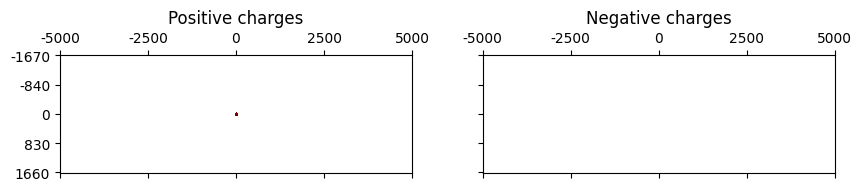

<Figure size 1000x400 with 0 Axes>

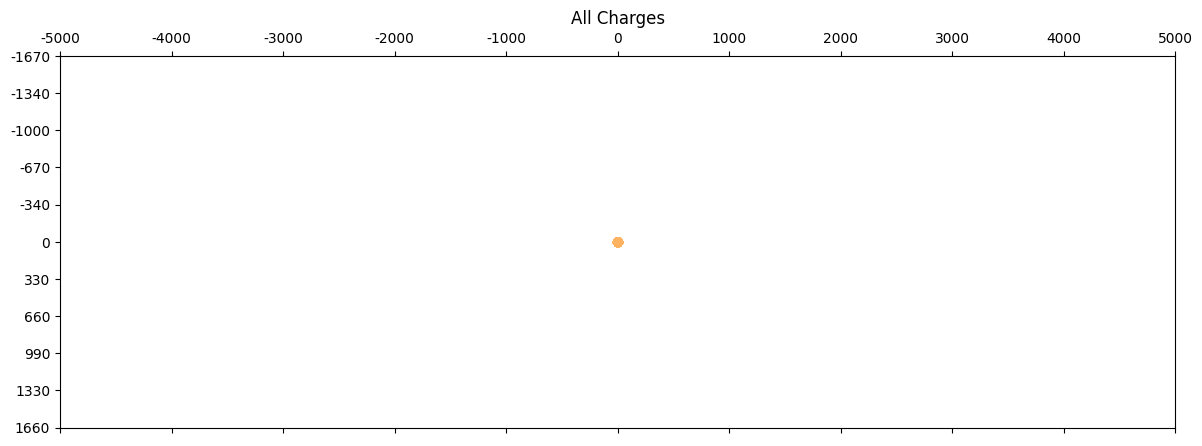

<Figure size 640x480 with 0 Axes>

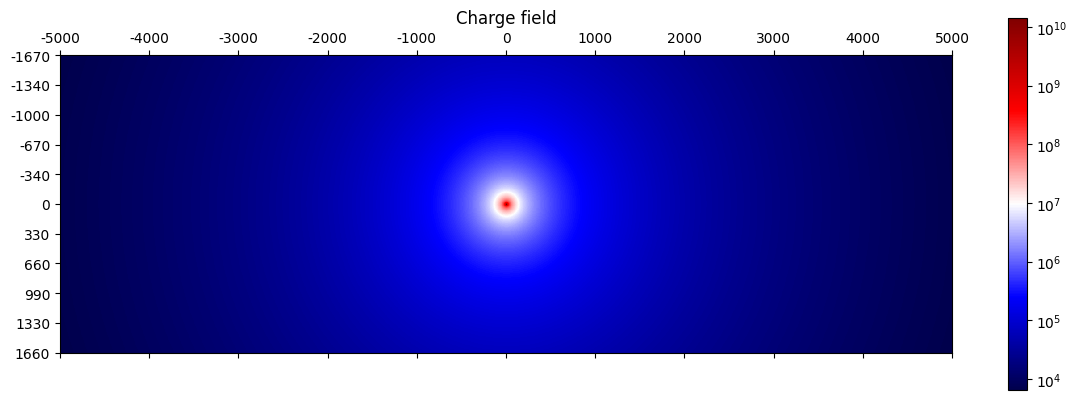

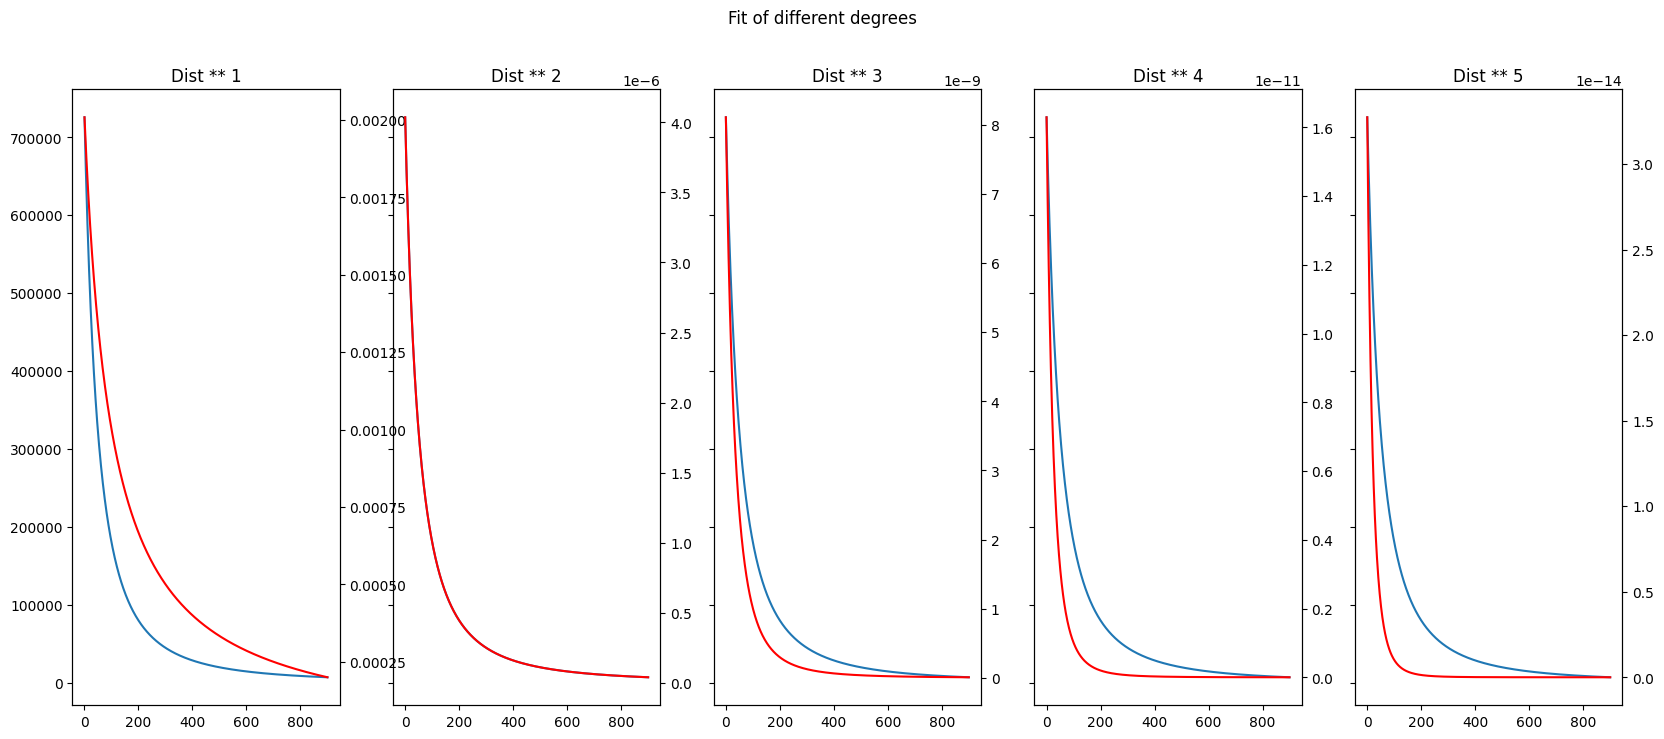

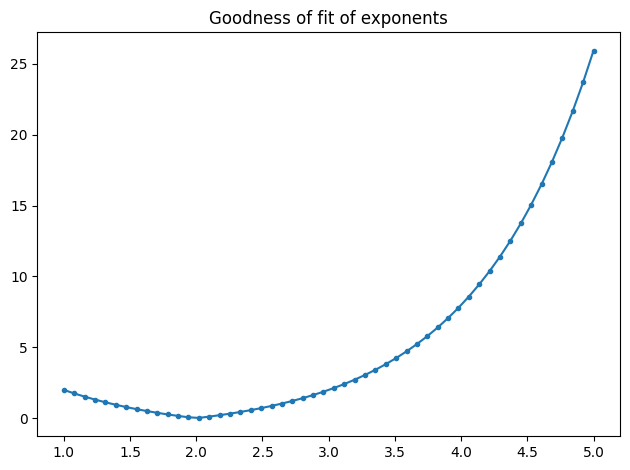

In [7]:
show_case(point)

# Yet another sanity check
Charge from a dipole should fall off as 1/r^3 

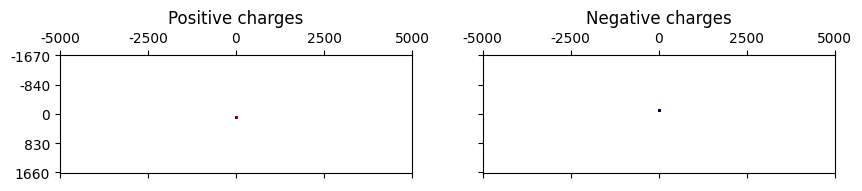

<Figure size 1000x400 with 0 Axes>

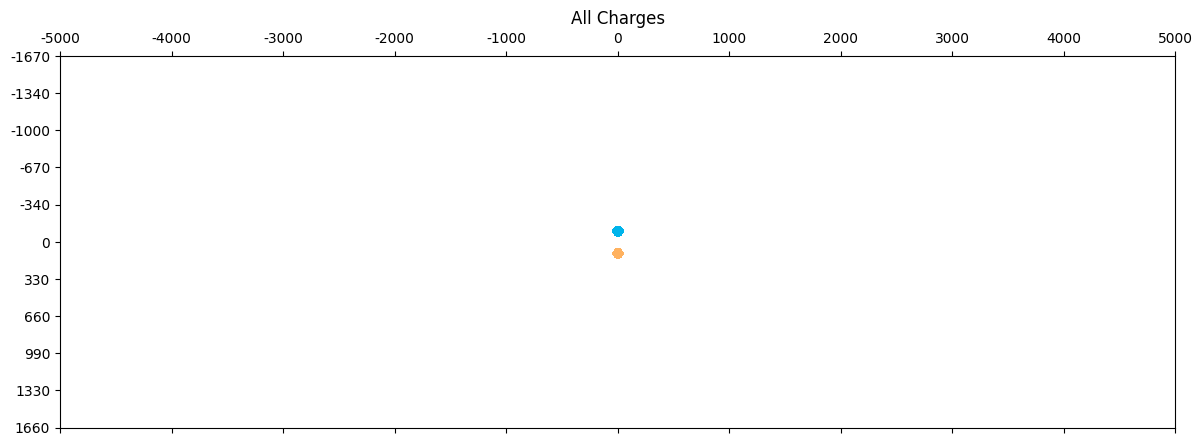

<Figure size 640x480 with 0 Axes>

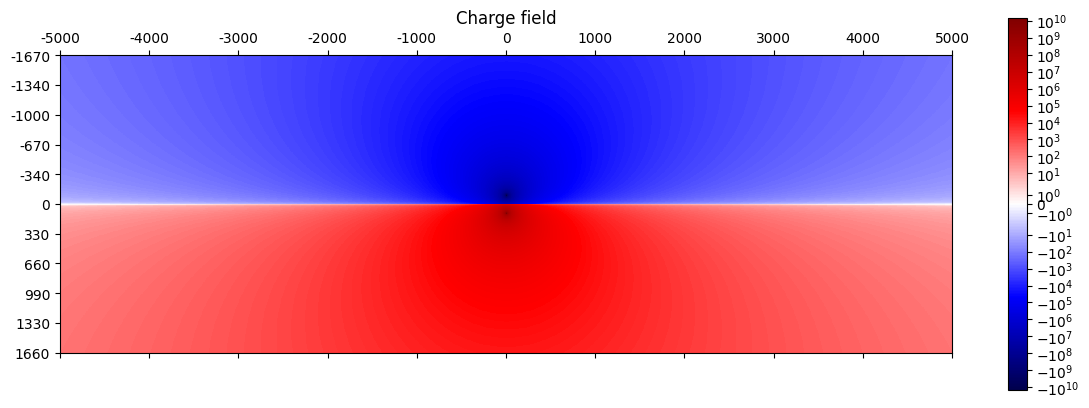

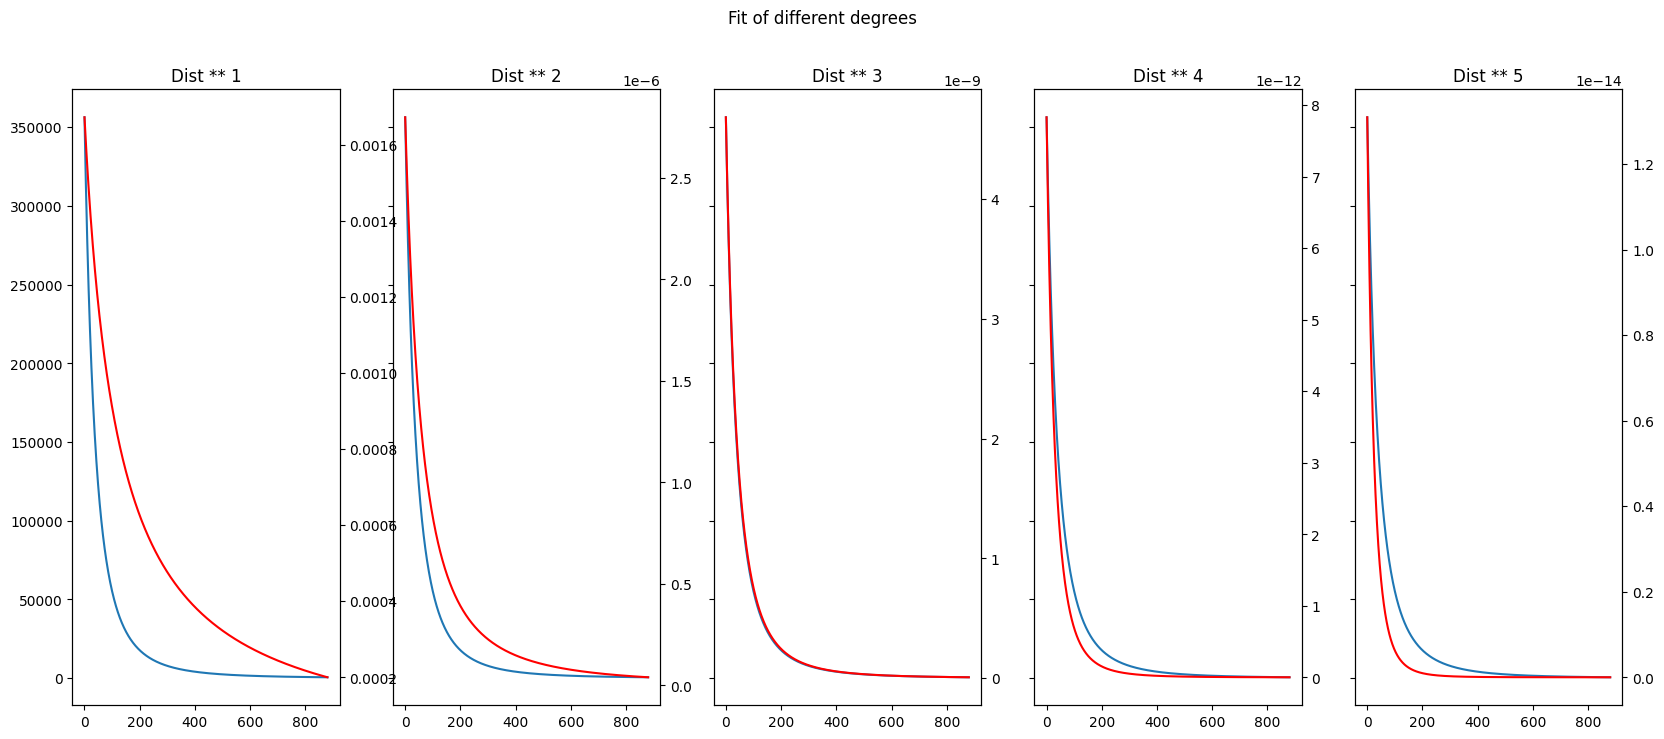

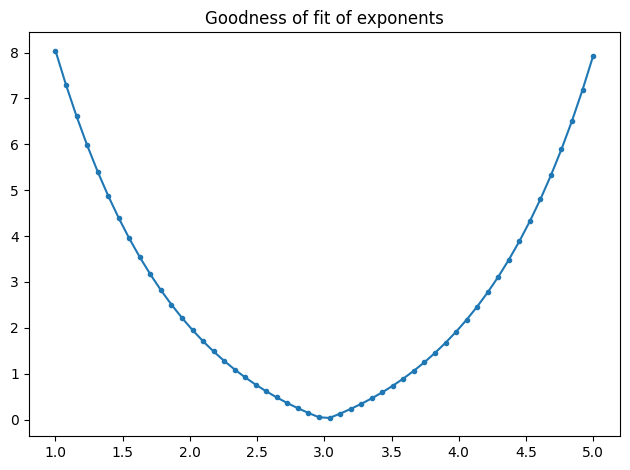

In [8]:
show_case(wide_dipole)

# I didn't know what should happen here

Winds up that four charges around a central charge falls off as 1/r^4. Extending to higher dimensions probably means that it falls off even faster?

Don't feel like modeling 3d space -- but this rate of falloff is probably what you'd see with an axon (surrounded on all sides in a two-dimensional slice)

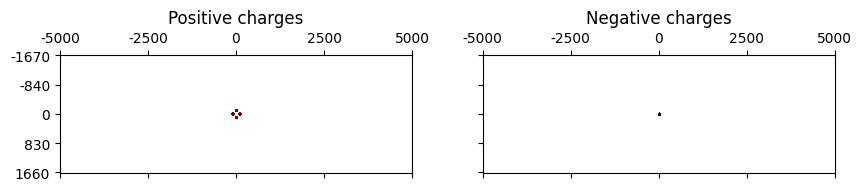

<Figure size 1000x400 with 0 Axes>

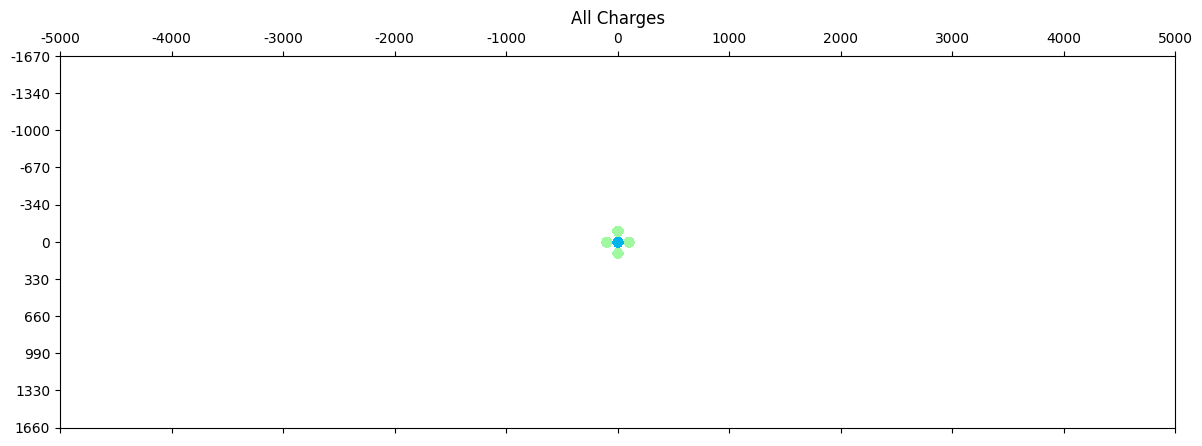

<Figure size 640x480 with 0 Axes>

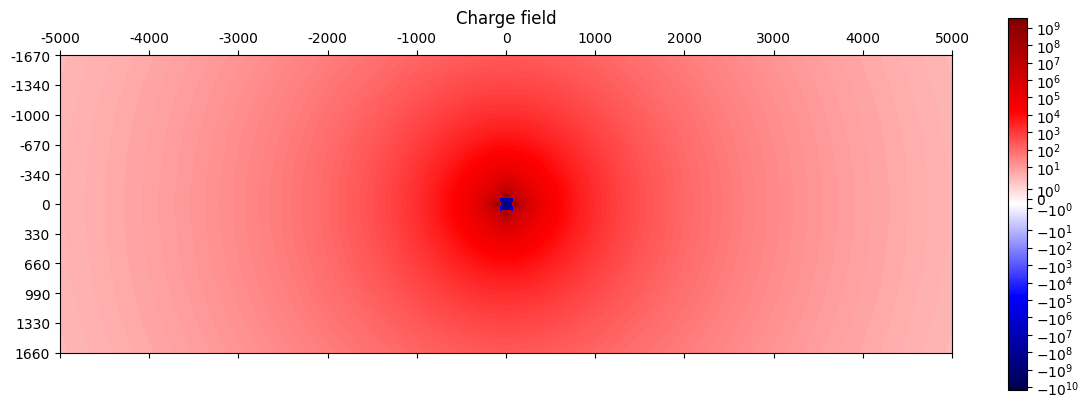

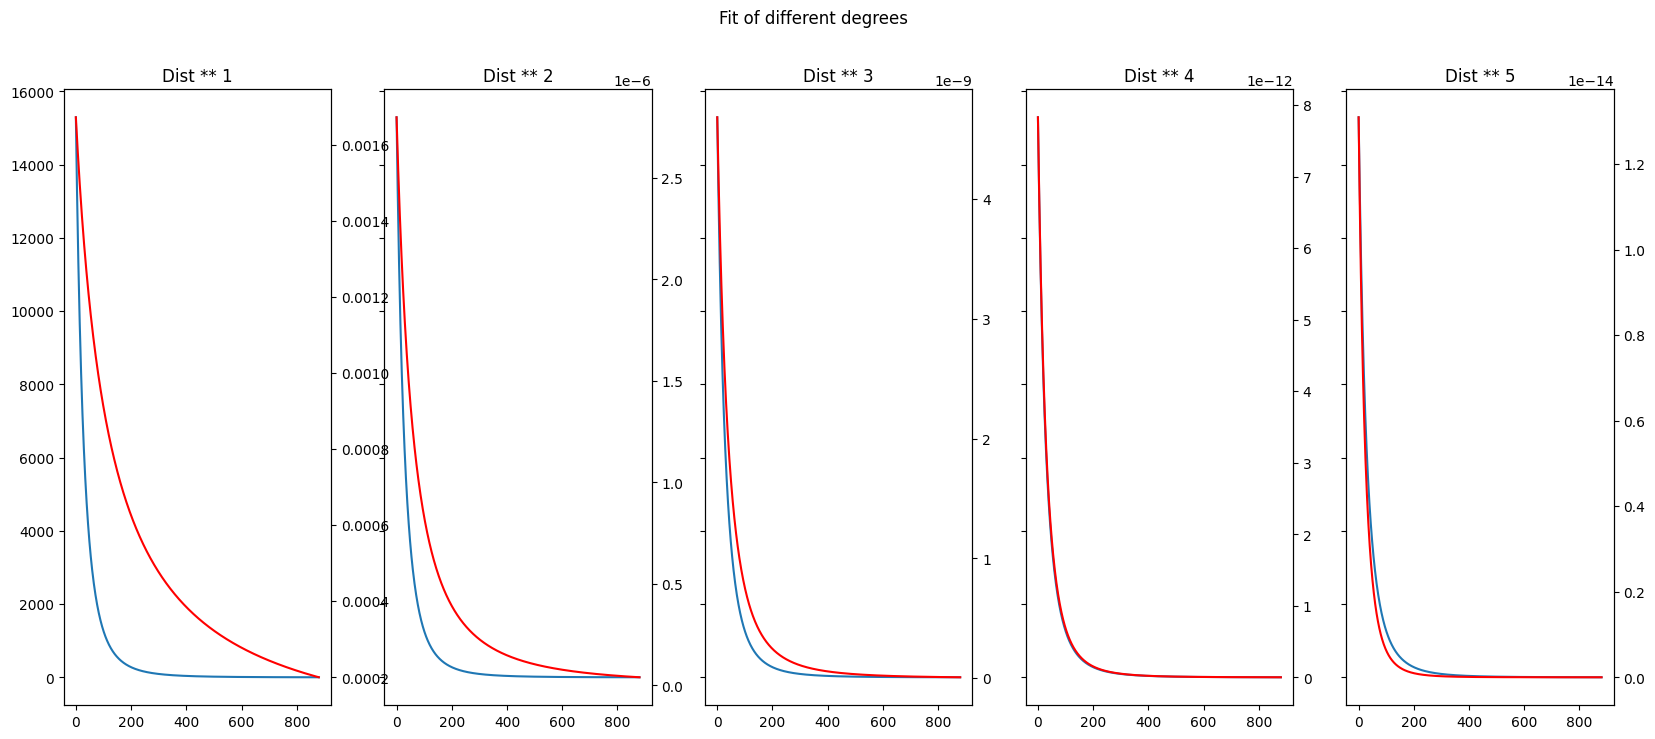

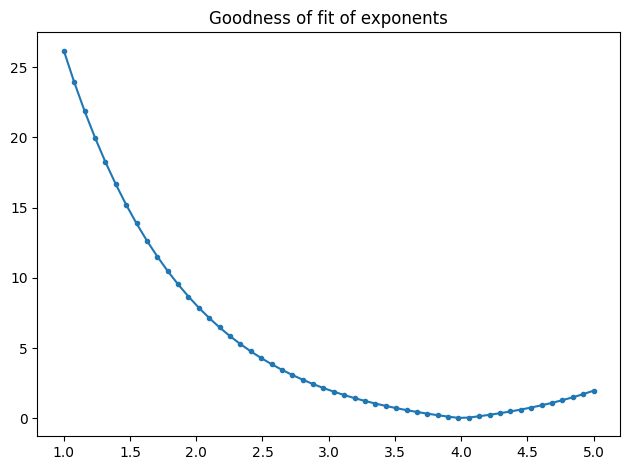

In [9]:
show_case(ring)

# Modeling an axon
Axon is modeled by positive charges (within the axon) and balanced negative charges outside of the myelin (a distance of 100nm away).

100nm was based on some very quick research as to myelin sheath thickness but may be off by orders of magnitude

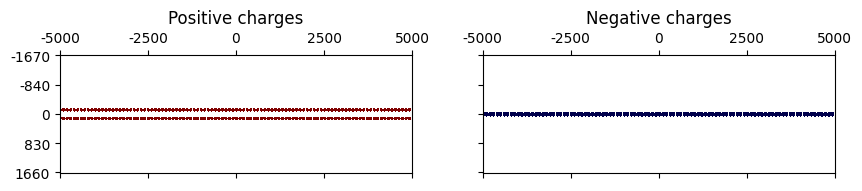

<Figure size 1000x400 with 0 Axes>

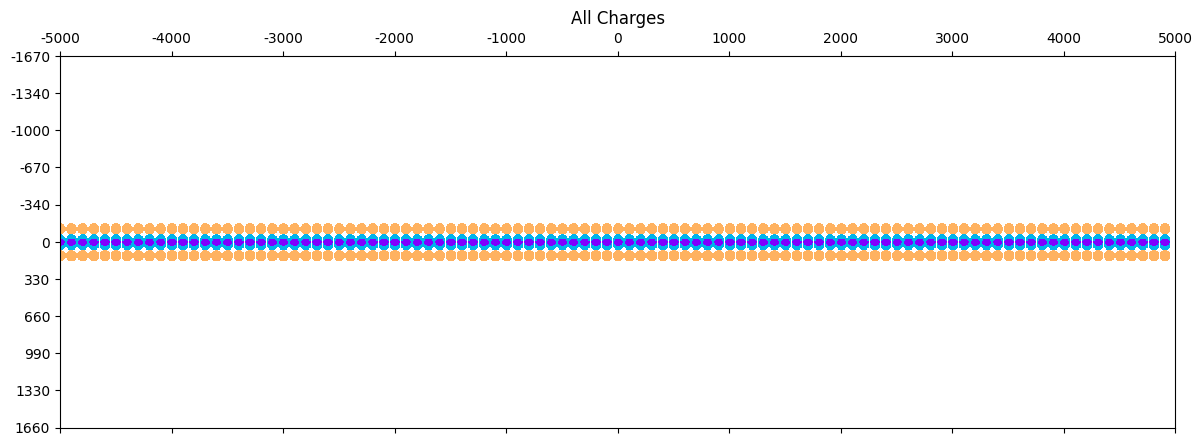

<Figure size 640x480 with 0 Axes>

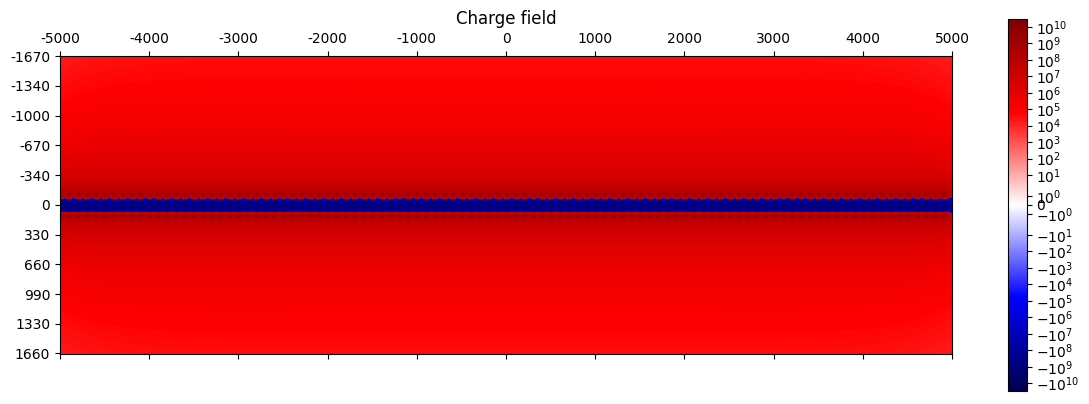

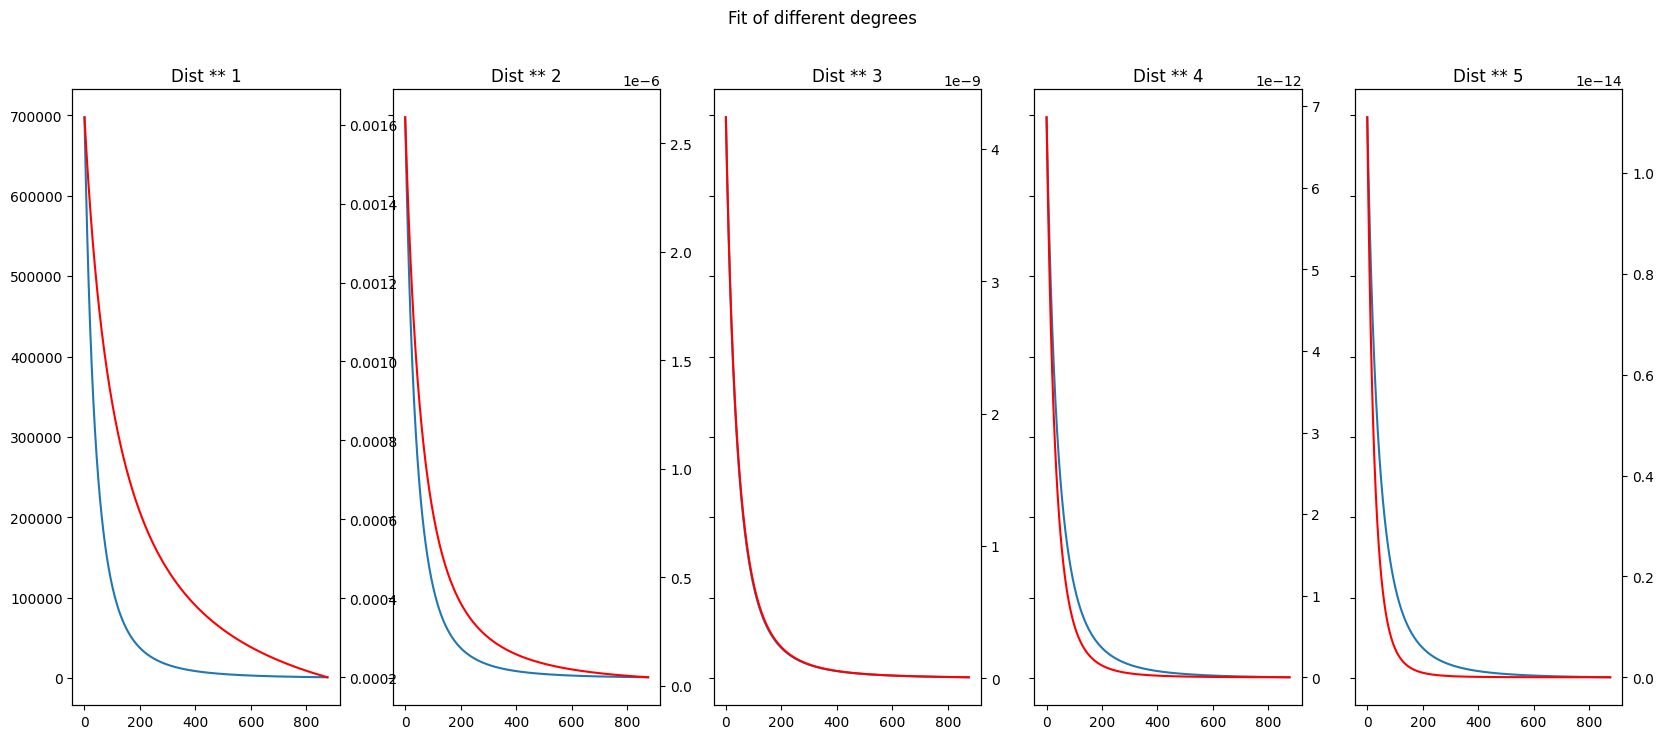

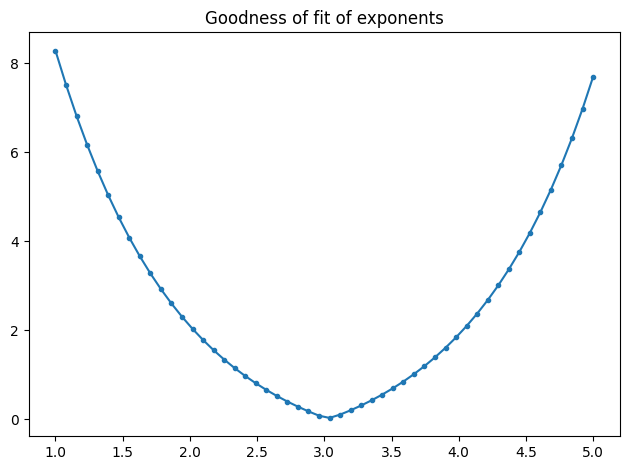

In [10]:
show_case(wide_tube)

# Node of ranvier
Width of separated charges gets narrower in the moiddle.

Note that near the node of ranvier, voltage measured on the outside of the axon tracks the inside, rather than the outside.

Falloff behavior is less useful in this case, because the voltage is doing weird shit. I assume farther away it would fall off as the cube, similar to the above example

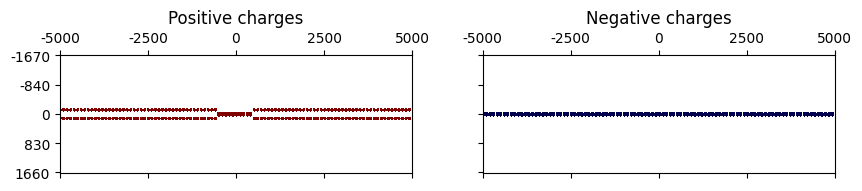

<Figure size 1000x400 with 0 Axes>

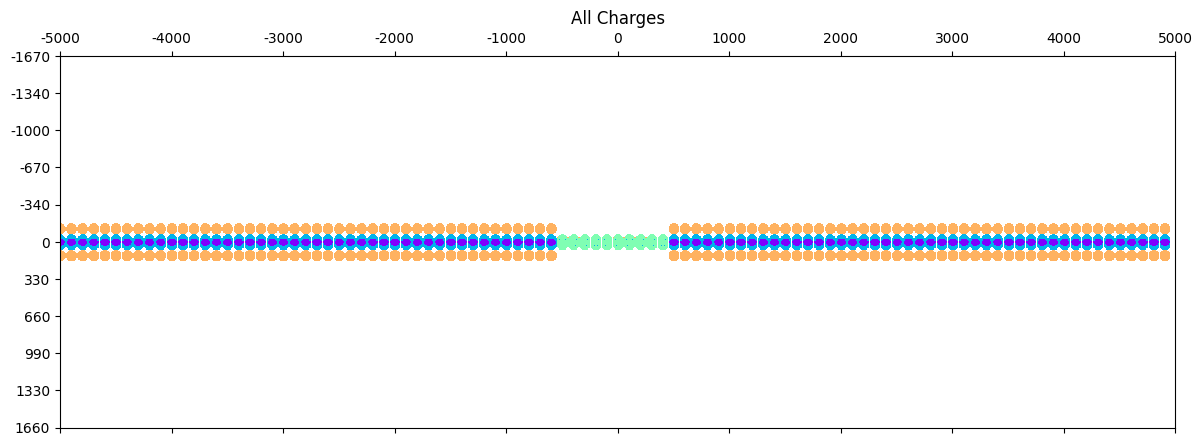

<Figure size 640x480 with 0 Axes>

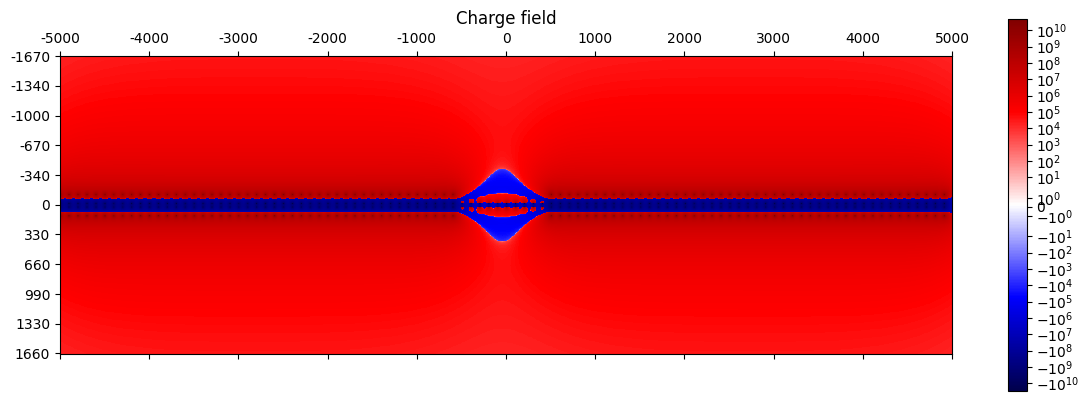

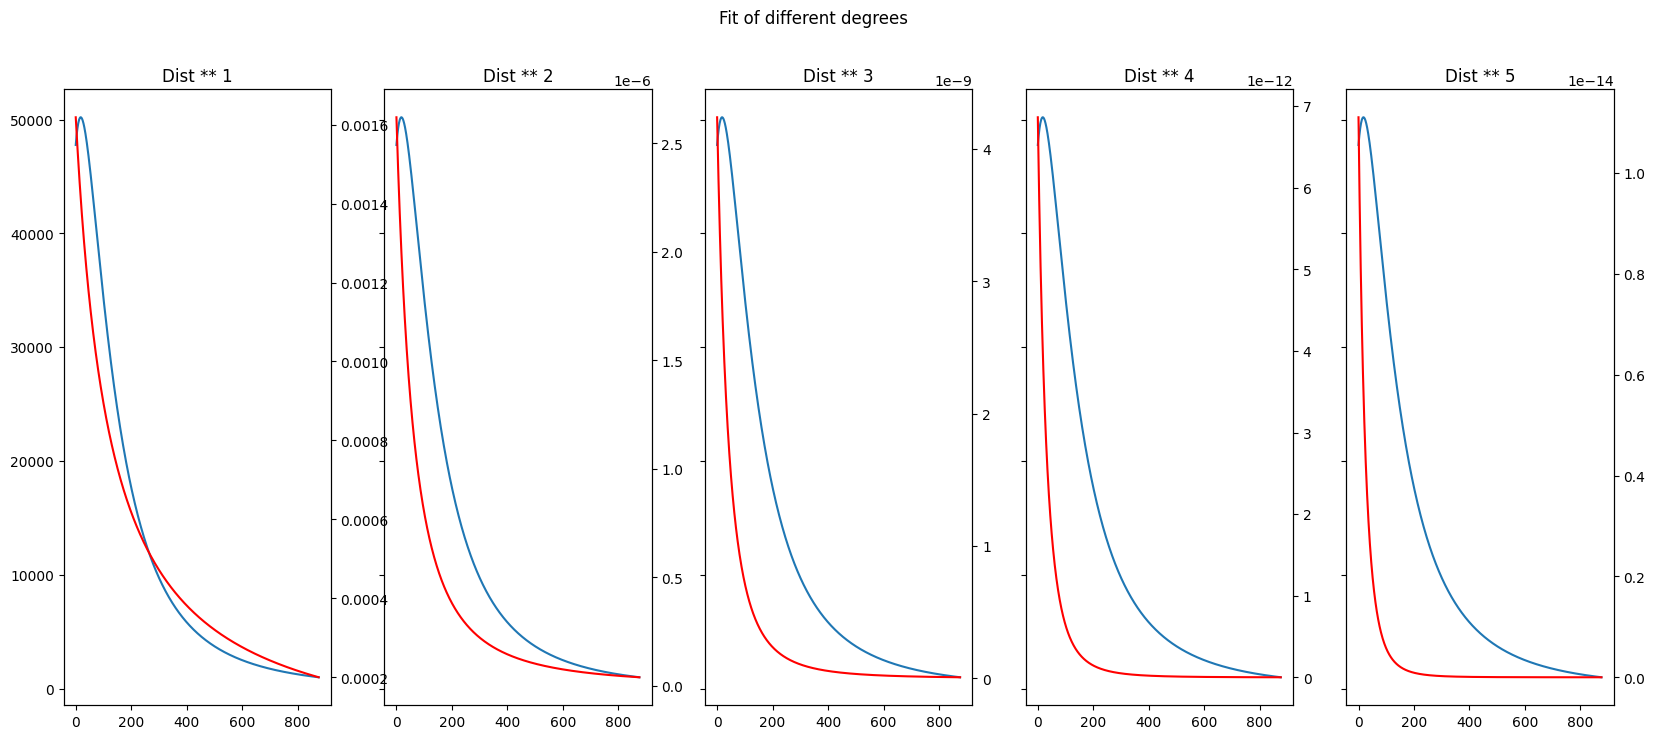

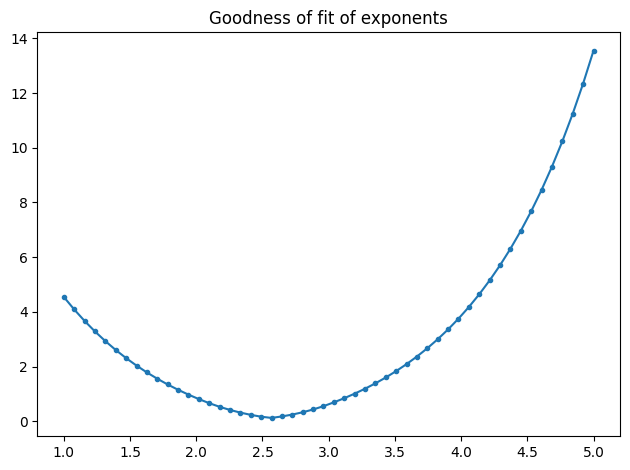

In [11]:
show_case(nofr)